In [1]:
import matplotlib.pyplot as plt
import networkx as nx

import math

In [2]:
class Cell:
    def __init__(self, x, y, occupancy = 'unknown'):
        #create a single cell
        self.x = x
        self.y = y
        self.occupancy = occupancy
    def __str__(self): 
        #string output of the class
        return "cell with coordinates (" + str(self.x) + "," + str(self.y) + ") and occupancy " + str(self.occupancy)


In [3]:
class Grid():
    def __init__(self, width, depth, span):
        #create a (width x depth) cell grid
        self.depth = depth
        self.width = width
        self.span = span
        self.cells = [] 
        for x in range(depth):
            row = []
            for y in range(width):
                row.append(Cell(x*span,y*span))
            self.cells.append(row)
    def __str__(self): 
        #string output of the class
        out = ""
        for x in range(self.depth):
            for y in range(self.width):
                out = out + "(" +str(self.cells[x][y].x) + ";" +str(self.cells[x][y].y) + ") " 
            out = out + "\n"
        return out
    
    def GetColor(self, cell, disp='center'):
        if disp == 'center':
            return '#bb5555'
        if disp == 'surface':
            if cell.occupancy == 'visited':
                return '#77bb77'
            else:
                return '#888888'
    
    def Display(self,robot="none"):
        # iterating through cells, displaying the grid
        fig, ax = plt.subplots(figsize=(12,8))
        span = self.span
        for x in range(self.depth):
            for y in range(self.width):
                cell = self.cells[x][y]
                
                # area of the cell (rect)
                col = self.GetColor(cell,'surface')
                rect = plt.Rectangle((cell.x-span/2, cell.y-span/2), span, span, linewidth=1, edgecolor='k', facecolor=col)
                ax.add_patch(rect)
                
                # center of the cell (circle)
                col = self.GetColor(cell,'center')
                circ = plt.Circle((cell.x*span, cell.y*span), 0.05, color=col)
                ax.add_patch(circ)
                
        # plotting the robot's pose (if there is a robot)
        if robot != "none":
            arrow = plt.Arrow(robot.x, robot.y, math.cos(robot.heading)*0.5, math.sin(robot.heading)*0.5, width=1.0, color = 'r')
            ax.add_patch(arrow)
            
            x_values = [robot.x, robot.x+2]
            y_values = [robot.y, robot.y]
            plt.plot(x_values, y_values,color='b')
             
            x_values = [robot.x, robot.x-2]
            y_values = [robot.y, robot.y]
            plt.plot(x_values, y_values,color='b')
             
            x_values = [robot.x, robot.x]
            y_values = [robot.y, robot.y+2]
            plt.plot(x_values, y_values,color='b')
             
            x_values = [robot.x, robot.x]
            y_values = [robot.y, robot.y-2]
            plt.plot(x_values, y_values,color='b')
            
            # plotting the robot's trace
            for i in range(0,len(robot.trace)-1):
                x_values = [robot.trace[i][0], robot.trace[i+1][0]]
                y_values = [robot.trace[i][1], robot.trace[i+1][1]]
                plt.plot(x_values, y_values,color='k')
                
        # setting boundaries of the plot
        ax.set_xlim(-1, self.span*self.width)
        ax.set_ylim(-1, self.span*self.depth)
        ax.axis('equal')
        plt.show()

In [4]:
class Robot():
    def __init__(self, x, y, heading):
        #create a robot with an initial pose
        self.x = x
        self.y = y
        self.heading = heading
        self.trace = [(x,y)]
        
        self.v = 0.6
        self.av = 0.1
        
    def __str__(self): 
        #string output of the class
        return "Robot with pose (" + str(self.x) +"," + str(self.y) +","+ str(self.heading) +")"
    
    def move(self, dx, dy, dh):
        mv = math.pow(math.pow(dx,2)+math.pow(dy,2),0.5)
        if mv > self.v:
            dx = (dx/mv)*self.v
            dy = (dy/mv)*self.v
            
        if dh > self.av:
            dh = self.av
            
        self.heading = self.heading + dh
        self.x = self.x + dx
        self.y = self.y + dy
        
        self.trace.append((self.x,self.y))
            
    def update(self,grid):
        for x in range(grid.depth):
            for y in range(grid.width):
                span = grid.span
                cell = grid.cells[x][y]
                xu = cell.x + span/2
                xl = cell.x - span/2                
                yu = cell.y + span/2
                yl = cell.y - span/2
                if(self.x < xu and self.x >= xl and self.y < yu and self.y>=yl):
                    grid.cells[x][y].occupancy = "visited"


In [5]:
robot0 = Robot(0,0,0)
robot0.move(2,2,0)

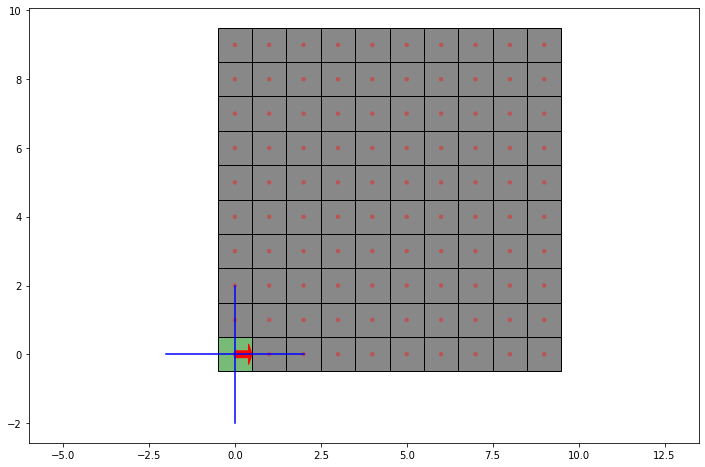

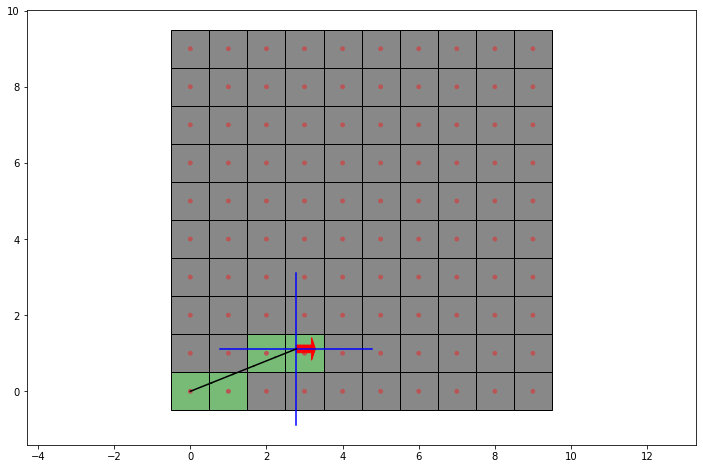

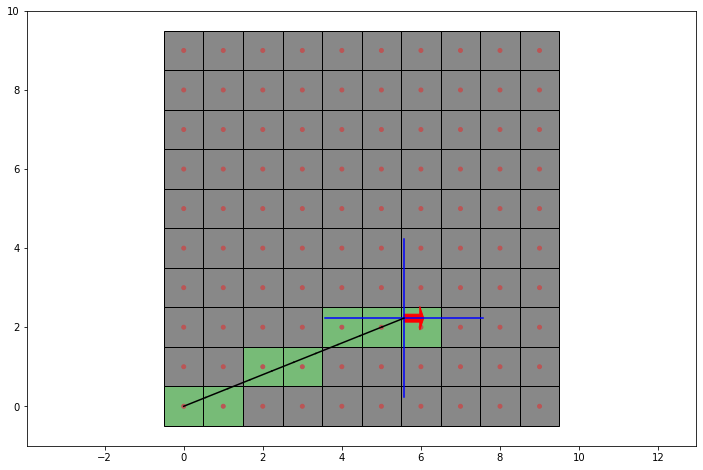

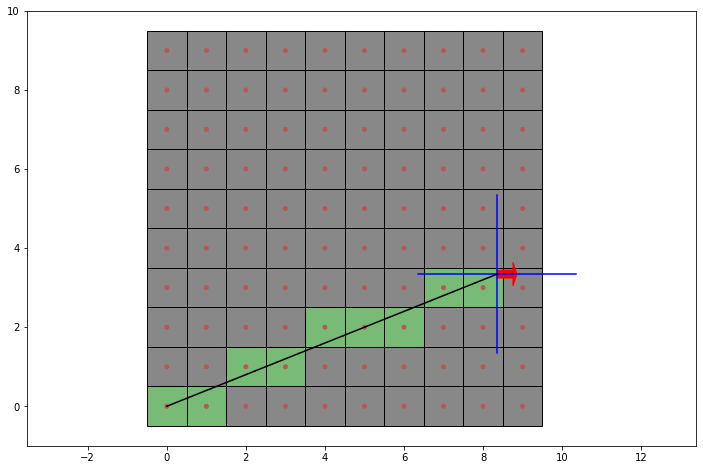

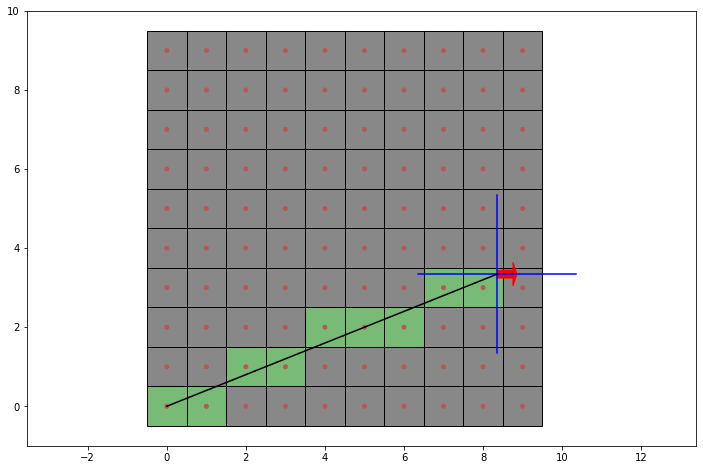

In [6]:
def step():
    robot0.move(5,2,0)
    robot0.update(grid)

robot0 = Robot(0,0,0)
grid = Grid(10,10,1)
robot0.update(grid)
grid.Display(robot0)

for i in range(3):
    for j in range(5):
        step()
    grid.Display(robot0)
    
grid.Display(robot0)

# Searching the landing area with obstacles

## general idea : 

1. separate the space in a grid pattern, construct a graph $G=(V,E)$ that describes the grid
2. find a minimum length path $P$ that passes through every vertex $v \in V$ (solve approximation of TSP), somewhere in that path is the landing area
3. navigate from one node of the path to the next, as we go through the path mark areas as explored
4. when detecting an obstacle mark the closest node as obstructed, remove it from the graph, rerun ??TSP?? on remaining graph
5. if we pass over the landing plateform, run the landing routine